GNM + RMSD vs xtal structure

In [3]:
#import 
import MDAnalysis as mda
from MDAnalysis.analysis import gnm
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
# prepare universe(s)
unis = list()      # create list of universes
refs = list()    # create list of reference universes
ulabels = ['298K', '490K']                      # universe labels
rlabels = ['solv','Acetone','CypA','FAB']       # reference xtal structure labels
labells = ['298K','298K','298K','298K','490K','490K','490K','490K']
fig_labl = ['Ace_298_SPC_Ace','Ace_298_SPC_Cyp','Ace_298_SPC_FAB','Ace_490_SPC_Ace','Ace_490_SPC_Cyp','Ace_490_SPC_FAB']

#'convention=STRUCT_T_SOLV_RMSDvs'

# target universes
unis.append(mda.Universe("md_0_1_298.gro","md_0_1_298.xtc"))
unis.append(mda.Universe("md_0_1_490.gro","md_0_1_490.xtc"))

# reference universes for xtal RMSD comparison
#refs.append(mda.Universe("csa_solv_ions.gro"))     # define the reference universe
refs.append(mda.Universe("gro_rmsdstructs/csa_acetone_noh.gro"))    # def ref unis
refs.append(mda.Universe("gro_rmsdstructs/csa_cyp_noh.gro"))    # def ref unis
refs.append(mda.Universe("gro_rmsdstructs/csa_fab_noh.gro"))    # def ref unis
for r in refs:
    r.trajectory[-1] # set to last frame

In [5]:
# prepare GNM
nma = list()            # 
eigenvalues = list()    
#time = list()

# calpha atoms (backbone)
for i in list(range(len(unis))):    # for the number of plots to be made on the same graph,
    nma.append(gnm.GNMAnalysis(unis[i], select='name CA', cutoff=7.0))    # create,
    nma[i].run()            #  run the analyses
    eigenvalues.append([res[1] for res in nma[i].results])      # calculate eigenvalues
    #time.append([res[0] for res in nma[i].results])             # calculate times

# sidechain atoms

In [6]:
time = list(range(5001))       # fix time differences (scale by 10)

In [7]:
#sel = 'not backbone and not type H and resnum 2:' 
#sel = 'resnum 1 and type C or type N and not backbone'
#print('Target uni:\t'+str(len(u.select_atoms(sel).positions)))
#for r in refs:
#    print('Reference uni:\t'+str(len(r.select_atoms(sel).positions)))

In [8]:
# prepare RMSD vs xtal structure
bb_rmss = list()
bb_rmsds = list()
bb_data = list()
sc_rmss = list()
sc_rmsds = list()
sc_data = list()

# backbone atoms
for u in unis:    # for all universes,
    for r in refs:  # for all reference structures,
        bb_rmss.append(rms.rmsd(u.select_atoms('backbone').positions, r.select_atoms('backbone').positions, center=True, superposition=True))  # append the rms analysis to the given position in rmss
        bb_rmsds.append(rms.RMSD(u, r, select='backbone', ref_frame=0))   # run RMSD analyses
for analysis in bb_rmsds:
    analysis.run()
    bb_data.append(pd.DataFrame(analysis.rmsd, columns=['Frame', 'Time (ps)', 'Backbone']))

In [9]:
bb_evs = [eigenvalues[0],eigenvalues[0],eigenvalues[0],eigenvalues[1],eigenvalues[1],eigenvalues[1]]
sc_evs = [eigenvalues[0],eigenvalues[0],eigenvalues[0],eigenvalues[1],eigenvalues[1],eigenvalues[1]]

In [10]:
dlist = list()

for i in bb_data:
    dlist.append(i.values.tolist())

In [35]:
#NECESSARY: parse the dataframes for precisely the data you need! test it out if you aren't sure...

#bb_data[1].plot(x='Time (ps)',)

# select the time and backbone w/in the dataframe,
df_times = bb_data[0]['Time (ps)']
#df_bbrmsd = bb_data[0]['Backbone']
df_bbrmsds = list()
bbrmsds = list()

for i in range(len(bb_data)):   # for analyses run, 
    df_bbrmsds.append(bb_data[i]['Backbone'])   # append bbrmsds
    bbrmsds.append(df_bbrmsds[i].values.tolist())
# and convert

# then convert to lists!
t_list = df_times.values.tolist()
#bbrmsd = df_bbrmsd.values.tolist()


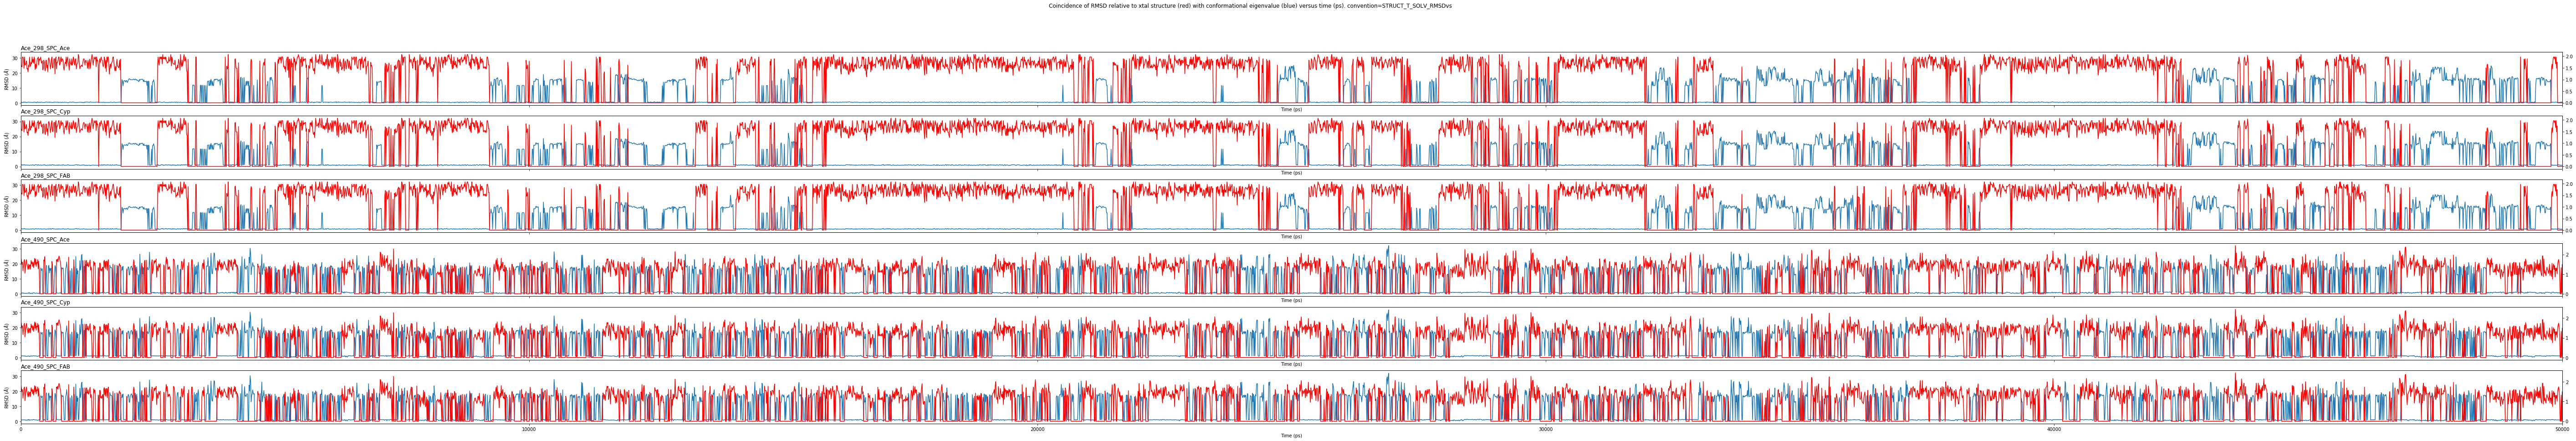

In [12]:
#pre-process/procure info from df
bb_rmsds = list()
for i in list(range(len(bb_rmss))):
    bb_rmsds.append(bb_data[i]['Backbone'])

# prepare large subplot
fig, axs = plt.subplots(6,1, sharex=True, sharey=True)
for i in list(range(len(axs))):
    #axs[i].plot(bb_data[i])
    #axs[i].plot(x='Frame', y=['Backbone'], kind='line')
    axs[i].plot(t_list, bb_rmsds[i])

    axs2=axs[i].twinx()
    axs2.plot(t_list, bb_evs[i], label=fig_labl[i], color='red')
    #axs.xlim(-1,5001)
    axs[i].set_xlim([-1,50001])      # set x limit for figure    
    #axs[i].legend(loc=3)
    axs[i].set_ylabel('RMSD ($\AA$)')
    axs[i].set_xlabel('Time (ps)')
    axs[i].set_title(fig_labl[i], loc='left')       # label with the specified labels (automate later!); move the title to the LHS of the page
    #axs[i].xticks(list(range(0,1000,50000)))

fig.set_size_inches(100,15)
fig.suptitle('Coincidence of RMSD relative to xtal structure (red) with conformational eigenvalue (blue) versus time (ps). convention=STRUCT_T_SOLV_RMSDvs')
#fig.savefig("subplots.pdf", bbox_inches="tight")

Extracting frames

In [65]:
# define functions

def xfromy_picker(lst, min, max):
    idxlist = list()        # create a list of indices (empty)
    for i in list(range(len(lst))):    # for a list of RMSDs in order (timesteps),
        if (lst[i] < max) and (lst[i] > min): # if the y-value is between min and max,
            idxlist.append(i)# append the index to a list of indices
    print('XFROMY_PICKER: '+str(len(idxlist))+' frames out of '+str(len(lst))+' matched the condition.')
    return idxlist

''' 
def retrieve_frames(idxlist):
    framelist = list()      # create a framelist
    for i in idxlist:   # for indices in idxlist,
        framelist.append()  # append the corresponding frames to a framelist
    return framelist    # return the framelist

def cluster_frames(framelist):
    #??? lol 
''' 

' \ndef retrieve_frames(idxlist):\n    framelist = list()      # create a framelist\n    for i in idxlist:   # for indices in idxlist,\n        framelist.append()  # append the corresponding frames to a framelist\n    return framelist    # return the framelist\n\ndef cluster_frames(framelist):\n    #??? lol \n'

In [67]:
stab_idxs = list()
trans_idxs = list()

for i in bb_rmsds:
    # stable indices
    stab_idxs.append(xfromy_picker(i, 0, 5))

    # transitional indices
    trans_idxs.append(xfromy_picker(i, 11, 13))
#print(idxs)

XFROMY_PICKER: 3678 frames out of 5001 matched the condition.
XFROMY_PICKER: 293 frames out of 5001 matched the condition.
XFROMY_PICKER: 3678 frames out of 5001 matched the condition.
XFROMY_PICKER: 295 frames out of 5001 matched the condition.
XFROMY_PICKER: 3678 frames out of 5001 matched the condition.
XFROMY_PICKER: 295 frames out of 5001 matched the condition.
XFROMY_PICKER: 3514 frames out of 5001 matched the condition.
XFROMY_PICKER: 175 frames out of 5001 matched the condition.
XFROMY_PICKER: 3514 frames out of 5001 matched the condition.
XFROMY_PICKER: 146 frames out of 5001 matched the condition.
XFROMY_PICKER: 3514 frames out of 5001 matched the condition.
XFROMY_PICKER: 162 frames out of 5001 matched the condition.


In [ ]:
# write "stable" structures (low rmsd) to a set of new files (PDB)

In [ ]:
# write unstable structures (b/w specific RMSD range) to a new set of files (PDB)

In [68]:
# select frames where match-up between RMSD and eigenvalue is different; what's common/different compared b/w them?

In [57]:
# define base transition 
def base_trans(lst, idx, down, up):
    if (lst[idx]<down) and (lst[idx+1]>up):    # if the previous frame has RMSD below 1 and the next frame has RMSD > 5,
        return 1
    else:
        return 0

# transitions b/w states
def count_transs(lst):
    transs = list()             # create a list of indices where the transition "up" occurs
    for i in list(range(len(lst)-1)):    # for frames in the traj, to the 2nd to last
        if base_trans(lst, i, 2, 5):   # if the trajectory goes from down to up,
            transs.append(i)    # append frame to a list 
    cnt = len(transs)           # number of transitions
    print('COUNT_TRANS: There were '+str(cnt)+' transitions.')
    return cnt, transs          # return both the count and the list of frames w/trans    

In [54]:
count, trans_list = count_transs(bbrmsd)

COUNT_TRANS: There were 215 transitions.


In [60]:
counts = list()
transs = list()
for i in bb_rmsds:
    c, t = count_transs(i)
    counts.append(c)
    transs.append(t)

print('Ratio: ',counts[3]/counts[0])

COUNT_TRANS: There were 215 transitions.
COUNT_TRANS: There were 215 transitions.
COUNT_TRANS: There were 215 transitions.
COUNT_TRANS: There were 517 transitions.
COUNT_TRANS: There were 517 transitions.
COUNT_TRANS: There were 517 transitions.
Ratio:  2.4046511627906977


In [84]:
with mda.Writer('gro_rmsdstructs/csa_acetone_noh.gro', 'w', n_atoms=u.atoms.n_atoms) as w:
    for ts in u.trajectory[0]:        
        w.write(u.atoms)

u_with_box = mda.Universe(PSF, 'with_box.trr')

TypeError: 'Universe' object is not subscriptable

In [80]:
#for i in transs:
#    print(u.trajectory[i])